In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import time

In [2]:
payload = '{"cuni":"37665566"}'
r = requests.post('https://ies-midterm.soulution.rocks/login',payload)
r #everything is ok

<Response [200]>

In [3]:
r_next = json.loads(r.text)
r_next

{'data': {'personal_code': '19e0bf64',
  'dataset_ids': ['f45ec2e9fc',
   '557b58dd1d',
   'e2beb850b2',
   '5aa21103e8',
   '3bd4cabfaa']},
 'message': 'Hello, Bajcár Tomáš! Good luck with the midterm. GET your data set from /data/file_id endpoint; use the codes you received in the data response as the file_id parameter! Print the personal code in your notebook.'}

In [4]:
r_next['data']['personal_code'] #my personal code

'19e0bf64'

In [5]:
my_codes = r_next['data']['dataset_ids']
my_codes

['f45ec2e9fc', '557b58dd1d', 'e2beb850b2', '5aa21103e8', '3bd4cabfaa']

In [6]:
pd.DataFrame([requests.get(f'https://ies-midterm.soulution.rocks/data/{code}').text for code in my_codes]) #I see errors here

,0
0,"{""data"": {""company"": ""AAL"", ""data"": [{""Date"": ..."
1,"{""data"": {""company"": ""AZN"", ""data"": [{""Date"": ..."
2,"{""data"": {}, ""message"": ""Error [503] - Sorry, ..."
3,"{""data"": {""company"": ""BME"", ""data"": [{""Date"": ..."
4,"{""data"": {""company"": ""AUTO"", ""data"": [{""Date"":..."


In [7]:
my_dictionary = {}
for code in my_codes:
    r = requests.get(f'https://ies-midterm.soulution.rocks/data/{code}')
    print(r) #checking what trials are passed on first attempt
    while r.status_code != 200:  
        r = requests.get(f'https://ies-midterm.soulution.rocks/data/{code}')
        time.sleep(5)
        print(r) #other attempts...I need response 200 five times 
    df = r.json()['data']
    
    comp_name = df['company']
    data_all = pd.DataFrame(df['data']).set_index('Date') #I came back here bcs I needed to create index and set it to datetime
    data_all.index = pd.to_datetime(data_all.index)
    
    my_dictionary[comp_name] = data_all
    
df_final = pd.concat(my_dictionary)
df_final.index.names = ['comp_name','Date']
df_final = df_final.dropna(how = 'all')
df_final = df_final.astype(float)

<Response [200]>
<Response [503]>
<Response [503]>
<Response [200]>
<Response [503]>
<Response [503]>
<Response [200]>
<Response [200]>
<Response [503]>
<Response [503]>
<Response [200]>


In [8]:
df_final.dtypes #checking types of my data

Open         float64
High         float64
Low          float64
Close        float64
Adj.Close    float64
Volume       float64
dtype: object

In [9]:
df_final.index.to_frame().dtypes #checking type of my multindex

comp_name            object
Date         datetime64[ns]
dtype: object

In [10]:
df_final 

Open       High        Low      Close  Adj.Close  \
comp_name Date                                                                
AAL       2019-01-02  31.459999  32.650002  31.049999  32.480000  31.963160   
          2019-01-03  31.690001  31.850000  28.809999  30.059999  29.581665   
          2019-01-04  30.440001  32.090000  30.400000  32.040001  31.530161   
          2019-01-07  31.990000  33.480000  31.240000  32.950001  32.425678   
          2019-01-08  33.360001  33.650002  32.200001  32.419998  31.904110   
...                         ...        ...        ...        ...        ...   
AUTO      2020-11-16   2.310000   2.390000   2.260000   2.290000   2.290000   
          2020-11-17   2.330000   2.390000   2.230000   2.320000   2.320000   
          2020-11-18   2.310000   2.350000   2.240000   2.310000   2.310000   
          2020-11-19   2.300000   2.720000   2.260000   2.640000   2.640000   
          2020-11-20   2.680000   2.720000   2.520000   2.610000   2.610000   

                          Volume  
comp_name Date                    
AAL       2019-01-02   5229500.0  
          2019-01-03  16822000.0  
          2019-01-04   9369600.0  
          2019-01-07   8010700.0  
          2019-01-08   7107700.0  
...                          ...  
AUTO      2020-11-16    179300.0  
          2020-11-17    196900.0  
          2020-11-18    341200.0  
          2020-11-19    974700.0  
          2020-11-20    513700.0  

[2390 rows x 6 columns]

In [ ]:
# Part 2

In [11]:
#what is the highest and lowest Adj Close price the company recorded? 
print(df_final.groupby('comp_name')['Adj.Close'].max()) #highest
print(df_final.groupby('comp_name')['Adj.Close'].min()) #lowest

comp_name
AAL     36.441425
AZN     60.615417
IAG      5.200000
BME     46.650002
AUTO     5.370000
Name: Adj.Close, dtype: float64
comp_name
AAL      9.040000
AZN     33.386486
IAG      1.880000
BME     26.664894
AUTO     0.670000
Name: Adj.Close, dtype: float64


In [12]:
#what day was the highest number of shares traded
df_final.groupby('comp_name')['Volume'].idxmax()

comp_name
AAL      (AAL, 2020-06-05 00:00:00)
AZN      (AZN, 2020-07-20 00:00:00)
IAG      (IAG, 2020-02-24 00:00:00)
BME      (BME, 2020-03-23 00:00:00)
AUTO    (AUTO, 2020-08-27 00:00:00)
Name: Volume, dtype: object

In [13]:
#what is the total of shares traded
df_final.groupby('comp_name')['Volume'].sum()

comp_name
AAL     1.664048e+10
AZN     2.151856e+09
IAG     2.633248e+09
BME     1.816650e+07
AUTO    9.555050e+07
Name: Volume, dtype: float64

<AxesSubplot:title={'center':'Share Price Development'}, xlabel='Date', ylabel='Adj.Close'>

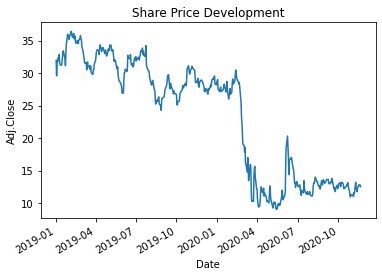

In [14]:
#for the company with the highest volume of shares traded over the whole period, plot their share price over time 
df_final.loc['AAL',:]['Adj.Close'].plot(title = 'Share Price Development', ylabel = 'Adj.Close')